# Consistency check 3

In this file I check the consistency of the thermalization. I evolve in an exact manner the thermal state and do the same with the TEDB algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [2]:
### PROBLEM PARAMETERS
L = 8         # chain length
omega = 1     # Rabi frequency
V = 0.1       # B-S interaction strength
V_ = 1        # bath interaction strength
beta = 0.001  # inverse temperature for the bath

T = 10        # total time of the simulation
dt = 0.1      # time step for coherece vector time evolution

cutoff = 1e-8 # cutoff for TEBD algorithm

### USEFULL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('Y')
Z = qu.pauli('Z')

In [3]:
def isherm(M):
    return (M.H - M == 0).all()

### Exact simulation

In [4]:
### BUILDING THE HAMILTONIAN

# fisrt I build the operators
nn_op = (I + Z)/2 & (I + Z)/2

print(f'Building Hamiltonian for L={L}')
# the hamiltonian
H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

# diagonalization
e, U = la.eig(H, isherm=True)

print('done :)')

Building Hamiltonian for L=8
done :)


In [5]:
### BUILDING THE OBSERVABLES

observables_ex = {}
results_ex = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results_ex[key] = []
    observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

# dropping the identity
observables_ex.pop('I1I2')
results_ex.pop('I1I2')


### INITIAL CONDITIONS
print('Initial state: random subsystem and thermal bath\n')

#rho = la.expm(-beta*H)
#rho /= rho.trace()

rho = qu.gen.states.thermal_state(H, beta)

# apply a random operator to the first two spins
rand1 = qu.gen.rand.rand_uni(2)
rand2 = qu.gen.rand.rand_uni(2)
U_rand = qu.ikron(rand1 & rand2, dims, (0, 1))
rho = U_rand @ rho @ U_rand.H

### THE SIMULATION

# smarter way to calculate the coherence vector:
rho_tilde = np.conj(U.T) @ rho @ U    

pauli_tilde = {}
t = []
for key in observables_ex.keys():
    pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U
    
for i in range(0, int(T/dt)):
    ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
    rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)
        
    trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
    for key in results_ex.keys():
        results_ex[key].append(trace(key))
        
    t.append( dt*i )
        
print("finished Time = %s" % T)
    
print('done')

Initial state: random subsystem and thermal bath

finished Time = 10
done


In [ ]:
keys = results_ex.keys()
keys = ['I1Z2', 'Z1I2', 'Z1Z2', 'Z1X2']

for key in keys:
    plt.plot(t_ex, results_ex[key], label=key)
plt.legend()
plt.grid()

### TEBD

In [24]:
### BUILDING THE HAMILTONIAN for the thermalization

O_Rabi = (omega/2)*X & I
N = (I + Z)/2 & I

print(f'Building Hamiltonian for L={L} \n')
# the hamiltonian
H1 = {i: O_Rabi for i in range(L)}
H2 = {None: V_*N&N, (L-1, 0): V*N&N, (0, 1): V*N&N, (1, 2): V*N&N}

H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

### BUILDING THE SPIN CHAIN

print('Building the spin chain \n')
B = np.array([1, 0, 0, 1])/np.sqrt(2)
arrays = [B for i in range(L)]

psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

psi.show()

Building Hamiltonian for L=8 

Building the spin chain 

 1 1 1 1 1 1 1 1 1 
+─●─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │ │  


In [25]:
print(f'Check for the normalization: {psi.H @ psi}\n')

Check for the normalization: 0.9999999999999982



In [26]:
### IMAGINARY TIME EVOLUTION

print('Imaginary time evolution \n')

# create the object
tebd_th = qtn.TEBD(psi, H, imag=True)

# cutoff for truncating after each infinitesimal-time operator application
tebd_th.split_opts['cutoff'] = 1e-12

tebd_th.update_to(beta/2, tol=1e-6)
psi_th = tebd_th.pt

psi_th.show() 

Imaginary time evolution 



t=0.0005, max-bond=4: 100%|################################################################################################################################| 100/100 [00:00<00:00, 4039.43%/s]

 2 2 2 2 3 2 3 2 2 
+─●─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │ │  


In [27]:
print(f'Check for the normalization beta/2: {psi_th.H @ psi_th}\n')

Check for the normalization beta/2: 0.500000002508025



In [28]:
### INITIAL CONDITIONS

# random initial conditions
Rand1 = rand1 & qu.pauli('I')
Rand2 = rand2 & qu.pauli('I')

psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')
#psi_init = psi_th.copy()
psi_init.show()

 2 2 2 2 3 2 3 2 2 
+─●─●─●─●─●─●─●─●─+
  │ │ │ │ │ │ │ │  


In [29]:
print(f'Check for the normalization: {psi_init.H @ psi_init}\n')

Check for the normalization: 0.5000000025080246



In [ ]:
### THE SIMULATION

start = time.time()

# first I build the observables
observables_tebd = {}
results_tebd = {}
for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
    key = ob1 + '1' + ob2 + '2'
    results_tebd[key] = []
    observables_tebd[key] = []

# dropping the identity
observables_tebd.pop('I1I2')
results_tebd.pop('I1I2')
    
# create the object
tebd = qtn.TEBD(psi_init, H)

# cutoff for truncating after each infinitesimal-time operator application
tebd.split_opts['cutoff'] = cutoff

keys = results_tebd.keys()

# I can either set a timestep or a tolerance and the timestep is calculated accordingly
# generate the state at each time in t (same as exact simulation)
#     and target error 1e-3 for whole evolution
for psit in tebd.at_times(t, tol=1e-3):
    for key in keys:
        ob1 = qu.pauli(key[0]) & qu.pauli('I')
        ob2 = qu.pauli(key[2]) & qu.pauli('I')
        results_tebd[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)
        
end = time.time()
print(f'Time:{int(end - start)}s')

t=9.2, max-bond=111:  93%|#########################################################################################################################8         | 93/100 [02:44<00:32,  4.59s/it]

In [22]:
print(f'Check for the normalization: {tebd.pt.H @ tebd.pt}\n')

Check for the normalization: 0.5000000096855743



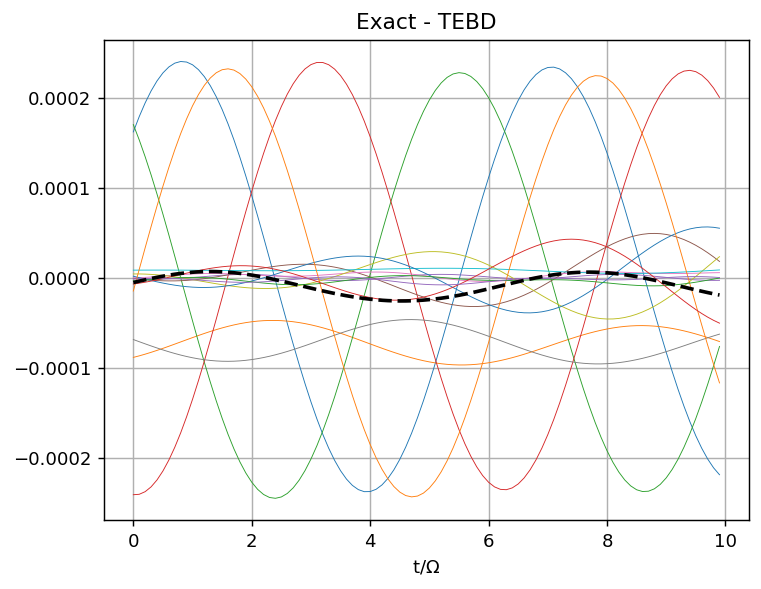

In [23]:
### PLOT
# here I plot the difference in the expectation values

keys = observables_tebd.keys()

diff = {}

plt.figure(dpi=130)#figsize=(9, 6))

for key in keys:
    diff[key] = [results_ex[key][i] - results_tebd[key][i] for i in range(len(t))]
    plt.plot(t, diff[key], linewidth=0.5)# label=key)
    
avrg = []
for i in range(len(t)):
    avrg.append(sum((diff[key][i] for key in keys))/15)
plt.plot(t, avrg, linewidth=2, linestyle='dashed', color='black')

plt.grid()
plt.xlabel(r't/$\Omega$')
plt.title('Exact - TEBD')

fig = plt.gcf()
#plt.legend()
plt.show()

#fig.savefig('./pictures/consistency_check_2_errors.pdf', dpi=150)

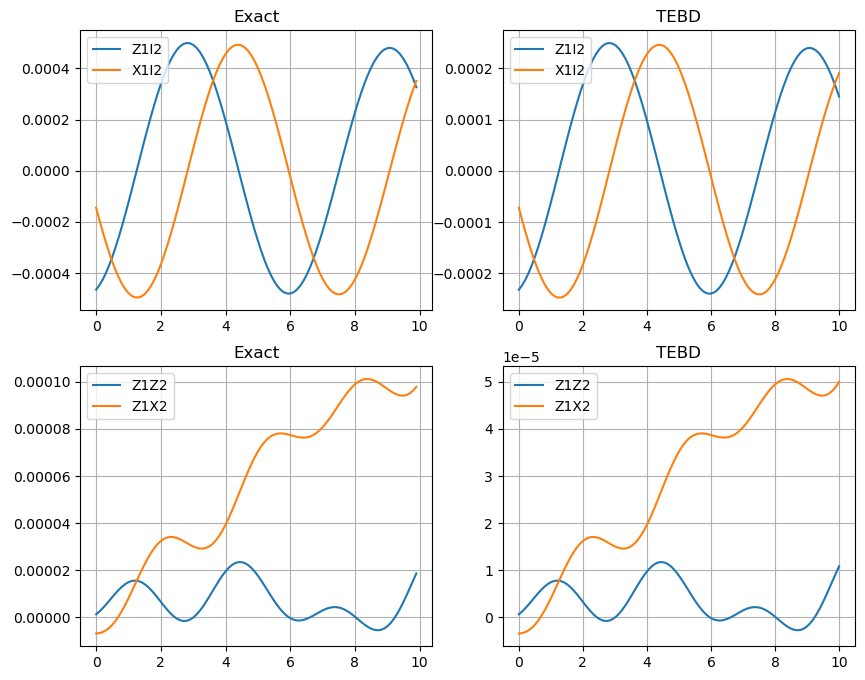

In [23]:
keys = observables_tebd.keys()
keys = ['Z1I2', 'X1I2']

fig, ax = plt.subplots(2, 2, figsize=(10,8))
for key in keys:
    ax[0][0].plot(t_ex, results_ex[key], label=key)
    ax[0][1].plot(t, results[key], label=key)    
ax[0][0].set_title('Exact')
ax[0][1].set_title('TEBD')

keys = ['Z1Z2', 'Z1X2']
for key in keys:
    ax[1][0].plot(t_ex, results_ex[key], label=key)
    ax[1][1].plot(t, results[key], label=key)
ax[1][0].set_title('Exact')
ax[1][1].set_title('TEBD')

for i in range(2):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()

#plt.savefig('./pictures/consistency_check_2.pdf')

In [26]:
(results['Z1X2'][0] - results_ex['Z1X2'][0])/(results['Z1X2'][0] )

0.9725034330768573

In [16]:
results['Z1I2'][0]*128

-7.999741685546842e-05

In [18]:
results_ex['Z1I2'][0]

-4.999187408918569e-05

In [53]:
2**7

128